In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 350
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")
import warnings
warnings.filterwarnings('ignore')

# Baseball Team Data

## Tyler Moncur

### Project Summary: 

#### Modeling Goal: 
The ultimate goal with this project is to model how people form into groups, and how these groups change over time. The secret purpose is to understand certain dangerous organizations, and predict how these groups will grow and change over time. But since the data on real dangerous organizations is classified and unavailable to this research project, data for baseball players will be used as a substitute. Baseball teams will change players at fixed intervals, which will be useful for analysis, and should approximate how teams change for the actual goal of this project.

#### Data Needs:
For every player, the model will only include information on the player's team and position. Even though far more baseball data is available for every player, only these features are used because that is the extent of the information available with the real version of this problem. Baseball data is readily available for download through the fangraphs.com website. Fangraphs is a well known site to baseball fans and is designed to provide any baseball data that could ever be useful. Fangraphs is the best of source of data for this project.

#### Previous Research:
The goal of this project can be formulated as a link prediction problem, but there are significant differences that make this problem distinct. The previous research on  the link prediction problem applies to undirected graphs that have nodes of the same type. Facebook friend prediction is the classic example of this type of link prediction. The challenge with the group formation problem is that using a graph to represent the data will create a bipartite graph between nodes that represent players and nodes that represent teams. The nodes are no longer of the same type, so this model will require either a new approach, or a significant modification to the standard link prediction problem. The state of art methods for Facebook link prediction have less than 5 percent accuracy, so it is expected that the modified problem will suffer from similar accuracy troubles.

## Data Collection

The only challenge with collecting the data was sorting through all of the options available on the fangraphs website. There are several small caveats that make this surprisingly complex. First, the data will be restricted to seasons that are after 1997 because there was a league expansion in that year that created several new teams. The true time period used is 2002-2016 because some data was missing from the years before 2002.  

Another question to answer for the data gathering process is "what qualified someone as a member of a team". This is not as black and white as one would expect. There is a minimum number of plate appearances for a player to be considered a qualified hitter, which an average of 3.1 plate appearances per game, or about 500 per season. We use 60 plate appearances as a low bar in order to include more people, but this restriction will help remove noise from players that only played a handful of games.

After making these decisions, it was a simple matter to select the information and download the player data. It was split into three csv files based on whether they were fielders, relief pitchers, or starter pitchers. Some players belonged to multiple categories, but this issue is handled in the data cleaning.

## Data Cleaning

In [2]:
teams_abbr = {'- - -': '- - -', 'ANA': 'Angels', 'ARI': 'Diamondbacks', 
 'ATL': 'Braves', 'BAL': 'Orioles', 'BOS': 'Red Sox', 'CHC': 'Cubs', 
 'CHW': 'White Sox', 'CIN': 'Reds', 'CLE': 'Indians', 'COL': 'Rockies',
 'DET': 'Tigers', 'FLA': 'Marlins', 'HOU': 'Astros', 'KCR': 'Royals', 
 'LAA': 'Angels', 'LAD': 'Dodgers', 'MIA': 'Marlins', 'MIL': 'Brewers',
 'MIN': 'Twins', 'MON': 'Expos', 'NYM': 'Mets', 'NYY': 'Yankees',
 'OAK': 'Athletics', 'PHI': 'Phillies', 'PIT': 'Pirates', 'SDP': 'Padres',
 'SEA': 'Mariners', 'SFG': 'Giants', 'STL': 'Cardinals', 'TBD': 'Devil Rays', 
 'TBR': 'Rays', 'TEX': 'Rangers', 'TOR': 'Blue Jays', 'WSN': 'Nationals'}

One of csv files listed the teams by abbreviations. To solve this problem, the above dictionary maps the abbreviations to the proper team name.

#### Read Data and Change Team Abbreviation

In [3]:
#read in all data
sp = pd.read_csv('FanGraphs_Starters.csv')
rp = pd.read_csv('FanGraphs_Relievers.csv')
fd = pd.read_csv('FanGraphs_Fielders.csv')

a, b, c = len(sp),len(rp),len(fd)
print(
"""Number of starter pitchers:   {}
Number of relief pitchers:    {}
Number of fielders:           {}
-------------------------------------
Total number of records:      {}""".format(a, b, c, a+b+c))

#change abbreviation to full team name
fd['Team'] = fd['Team'].apply(teams_abbr.get)

Number of starter pitchers:   3370
Number of relief pitchers:    1798
Number of fielders:           19193
-------------------------------------
Total number of records:      24361


In [4]:
#create 3 sets containing tuples of playerids with the season for each record
fd_season_id = set([tuple(row) for row in fd[['playerid','Season']].values])
rp_season_id = set([tuple(row) for row in rp[['playerid','Season']].values])
sp_season_id = set([tuple(row) for row in sp[['playerid','Season']].values])

a, b, c = len(sp_season_id), len(rp_season_id), len(fd_season_id)
total = set()
total.update(sp_season_id);total.update(rp_season_id);total.update(fd_season_id)

print("Only counting players once per season.\n")
print("""Number of starter pitchers:   {}
Number of relief pitchers:    {}
Number of fielders:           {}
-------------------------------------
Total number of records:      {}""".format(a, b, c, len(total)))

Only counting players once per season.

Number of starter pitchers:   3370
Number of relief pitchers:    1798
Number of fielders:           14557
-------------------------------------
Total number of records:      15873


Aboves are the total number of records for each file when only counting players once per season. Whereas, the previous code outputs the total number of records, including player duplicates. At the end of data cleaning, each player should have at most one record per season. A quick analysis reveals that there are duplicate records in the fielders dataframe, the starting pitchers dataframe, and the total shows that there are numerous duplicates between the separate files.

#### Remove Duplicates Part 1

In [5]:
#create temporary Seasonid column
fd.insert(2,'Seasonid',[tuple(row) for row in fd[['playerid','Season']].values])
rp.insert(2,'Seasonid',[tuple(row) for row in rp[['playerid','Season']].values])
sp.insert(2,'Seasonid',[tuple(row) for row in sp[['playerid','Season']].values])

#find and remove duplicates between dataframes
mask = fd.Seasonid.isin(sp_season_id)
fd.drop(fd[mask].index,inplace=True)

mask = fd.Seasonid.isin(rp_season_id)
fd.drop(fd[mask].index,inplace=True)

mask = rp.Seasonid.isin(sp_season_id)
rp.drop(rp[mask].index,inplace=True)

#remove temporary Seasonid column
fd.drop('Seasonid',axis=1,inplace=True)
sp.drop('Seasonid',axis=1,inplace=True)
rp.drop('Seasonid',axis=1,inplace=True)

Resolve the issue for when players showed up in more than one of the files for a given season.

#### Reduce Number of Positions

In [6]:
#change all fielder positions (except catcher) to FD
fd.loc[fd.Pos.isin(['1B','2B','3B','RF','LF','CF','SS']),'Pos'] = 'FD'

#add column with potision to prepare for combining data
sp.insert(2, 'Pos', 'P')
rp.insert(2,'Pos', 'P')

At the recommendation of a knowledgable baseball fan (Hayden Ringer), the field positions will be grouped together since they are essentially interchangeable, with the exception of the catcher. In fact, players often switch fielding positions throughout the season, which explains why the data has the same player listed multiple times a season, once per position. This issue is addressed at the end of cleaning.  

#### Combine Data

In [7]:
p = pd.concat([sp,rp,fd], ignore_index=True)
p.drop(p[p.Season < 2002].index, inplace=True)
p.reset_index()
p.sample(5)

,Name,Pos,Season,Team,playerid
13448,Craig Wilson,FD,2003,Pirates,1015
9046,Ruben Tejada,FD,2016,- - -,5519
12995,Shawn Wooten,FD,2002,Angels,43
19052,Shawn Camp,P,2008,Blue Jays,1855
5926,David Wright,FD,2007,Mets,3787


Finally, all of the separate dataframes are combined into one.

#### Team Cleaning

In [8]:
#account for team name changes
p.loc[p.Team=='Devil Rays','Team'] = 'Rays'
p.loc[p.Team=='Expos','Team'] = 'Nationals'
del(teams_abbr['MON'])
del(teams_abbr['TBD'])

#delete players from a season if their team is unknown
p.drop(p[p.Team=='- - -'].index,inplace=True)
del(teams_abbr['- - -'])

These two teams, the Rays and the Nationals, changed cities partway through the time period 2002-2016, and their names also changed. To maintain continuity, the orginal names are kept instead of the new names.  

The "- - -" indicates that the player switched teams partway through a season. Since we don't know which specific team these players belonged to for this season, we remove them. This may be a source of error when we begin modeling, but it is realistic that we have incomplete information for the real problem anyway.

#### Removing Duplicates Part 2

In [9]:
print("Number of records before:    {}".format(len(p)))
p.drop_duplicates(inplace=True)
print("Number of records after:     {}".format(len(p)))

Number of records before:    17490
Number of records after:     13560


These duplicates occurred because many of the fielders play multiple positions, and they have a record for every position they played in a given season.

# Feature Engineering
#### Add a new field called Status

There isn't much that can or should be done for feature engineering on this dataset. The goal is to use the graph properties and its changes over time to predict future changes. So we want to know, based on previous baseball teams how teams might form and change in the future. With that in mind, it is important to label individuals based on whether they just arrived at a team in a given season or are leaving the team at the end of the season. Sometimes, players will do both.  

In [10]:
#initialize the new column with value 'Staying'
p.insert(1, 'Status', 'Staying')
by_player = p.groupby('playerid')

#loop through, player by player
for g in by_player.groups:
    one_p = by_player.get_group(g)
    
    #loop through the years for each player
    for y in sorted(one_p['Season'])[1:]:
        
        #Case: no change
        if sum(one_p.Season==y-1)==0: continue
        
        #Case: arrive
        if (one_p[one_p.Season==y].Team.values[0] != 
        one_p[one_p.Season==y-1].Team.values[0]):
            
            #Case: arrive and previous arrive/leave
            if (p[(p.Season==y-1)&(p.playerid==g)]['Status'].values[0]
            == 'Arrive'):
                p.loc[one_p[one_p.Season==y-1].index,'Status'] = 'Arriving Leaving'
                p.loc[one_p[one_p.Season==y].index,'Status'] = 'Arriving'
            
            #Case: arrive and previous leave
            else:
                p.loc[one_p[one_p.Season==y-1].index,'Status'] = 'Leaving'
                p.loc[one_p[one_p.Season==y].index,'Status'] = 'Arriving'

Below is the code for creating a dataframe with aggregated team data by each season.

In [11]:
by_season_team = p.groupby(['Season', 'Team'])
team_df = pd.DataFrame(index = range(len(by_season_team.groups)))
team_df['Season'] = [i[0] for i in by_season_team.groups]
team_df['Team'] = [i[1] for i in by_season_team.groups]


player_counts = []
pitcher_counts = []
catcher_counts = []
fielder_counts = []
for group_key in by_season_team.groups:
    cur_group = by_season_team.get_group(group_key)
    player_counts.append(len(cur_group))
    pitcher_counts.append(sum(cur_group.Pos=='P')) 
    catcher_counts.append(sum(cur_group.Pos=='C'))
    fielder_counts.append(sum(cur_group.Pos=='FD'))

team_df.insert(2, 'Players', player_counts)
team_df.insert(3, 'Pitchers', pitcher_counts)
team_df.insert(4, 'Catchers', catcher_counts)
team_df.insert(5, 'Fielders', fielder_counts)

# Visualization

Visualizing this data is challenging. The only features in this baseball data are the positions, status, seasons, and the graph properties. The focus here will be looking for trends over time, or general differences between teams. Finding patterns with any of these features will aid in predicting future configurations. But since the best link prediction accuracy is around 5 percent, any pattern at all will be helpful.

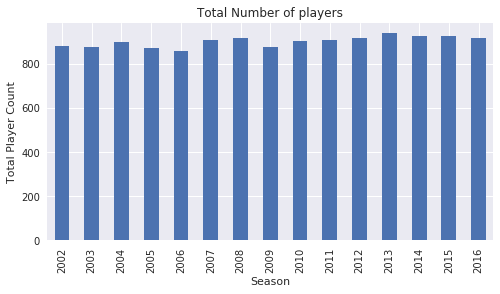

In [12]:
plt.figure(figsize=(8,4))
by_season = p.groupby('Season')
by_season['playerid'].count().plot(kind='bar', title='Total Number of players')
plt.ylabel('Total Player Count')
plt.show()

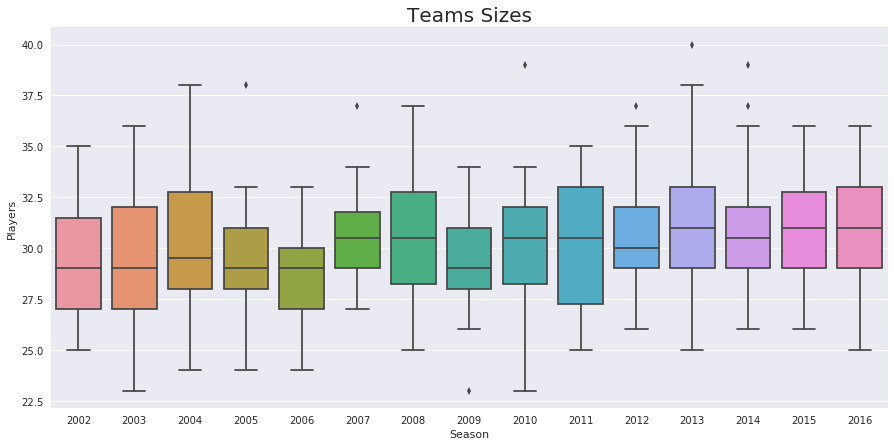

In [13]:
plt.figure(figsize=(15,7))
plt.title('Teams Sizes', fontsize=20)
sns.boxplot(y = 'Players', x ='Season', data=team_df)

plt.show()

The previous two figures are significant. The first shows that the total number of players is fairly constant, so the number of players retiring roughly balances the number of rookies. This will be an important aspect for building a model to understand group changes.  

The second figure shows boxplots of the number of players per team in a given season. The teams sizes stay close to 29 or 30 players, but every season has a few extremes. So the final model will need to account for variable team sizes. The other challenge is to understand what causes a team to shrink or grow more than the average team.

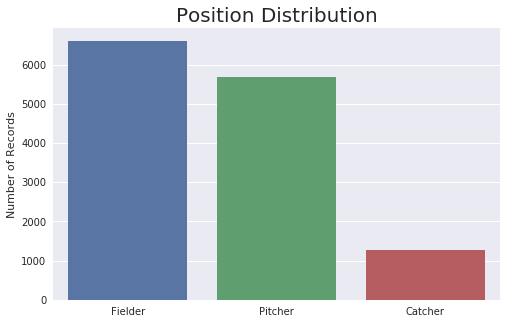

In [14]:
by_pos = p.groupby('Pos')
num_pos = len(p.Pos.unique())

plt.figure(figsize=(8,5))
plt.title("Position Distribution", fontsize=20)
sns.barplot([2,1,0], [len(df) for pos,df in by_pos.groups.items()])
pos_dct = {'P':'Pitcher', 'C':'Catcher', 'FD':'Fielder'}
plt.xticks([2,1,0], [pos_dct[pos] for pos,df in by_pos.groups.items()])
plt.ylabel("Number of Records")
plt.show()

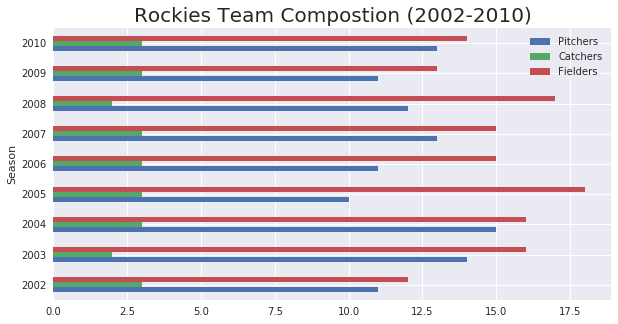

In [15]:
team_df[(team_df.Team=='Rockies')*(team_df.Season<=2010)].sort_values(by=
        'Season').plot(kind='barh', y=['Pitchers', 'Catchers', 'Fielders'],
        x='Season', figsize=(10,5))
plt.title('Rockies Team Compostion (2002-2010)', fontsize=20)
plt.show()

This visual only examines the composition of one team, the Rockies, over the time period 2002-2010. The most noticeable pattern is that the number of catchers is quite steady, and the fielders almost always outnumber to the pitchers. But beyond this, the numbers and the differences can widely vary. The Rockies had as many as 18 fielders in the 2005 season, and as few as 11 in 2009. And the maximum number of pitchers was 15, with a minimum of 10. But despite this variability, the distribution never looks drastically different from the distribution shown in the previous plot.

In [16]:
p08 = p[p.Season.isin(range(2008,1+2011))]

t_dct = {v:k for k,v in enumerate(p08.Team.unique())}
num_p = len(p08.playerid.unique())
num_t = len(p08.Team.unique())

A = np.zeros((num_t, num_p))

p08_dct = {v:k for k,v in enumerate(p08.playerid.unique())}

t = [0]*len(t_dct)
for team,num in t_dct.items():
    t[num] = team

for idx in p08.index:
    i = t_dct[p08.get_value(idx,'Team')]
    j = p08_dct[p08.get_value(idx,'playerid')]
    
    A[i,j] += 1

The above code creates the adjacency matrix between players and teams for the years 2008-2011.

### Adjacency Matrix: Inter-team Connections

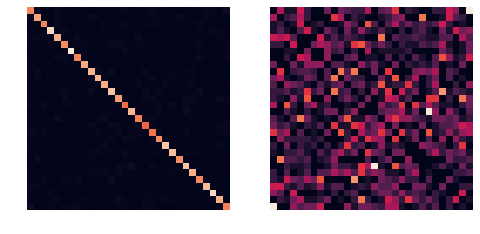

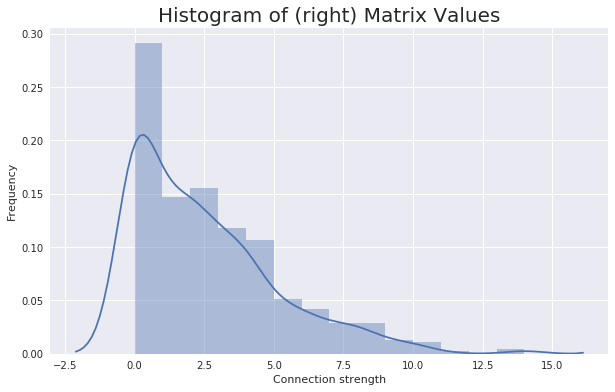

In [17]:
plt.figure(figsize=(8,8))
plt.subplot(121)
team2team = A.dot(A.T)
plt.imshow(team2team)
plt.axis('off')
plt.subplot(122)

team2team_no_diag = team2team-np.diag(np.diag(team2team))
plt.imshow(team2team_no_diag)
plt.axis('off')
plt.show()

plt.figure(figsize=(10,6))
sns.distplot(team2team_no_diag.ravel(), hist=True , bins=14)
plt.title("Histogram of (right) Matrix Values", fontsize=20)
plt.xlabel('Connection strength')
plt.ylabel('Frequency')
plt.show()

In [27]:
#P(Leaving|Pitcher)
pitchers = p[p.Pos=='P']
numer=pitchers.Status[pitchers['Status']=='Leaving'].count(); print('Number of Leaving Pitchers: {}'.format(numer))
denom = len(pitchers); print('Number of Pitchers: {}'.format(denom))
print('Ratio: {:.3f}'.format(numer/denom))

catchers = p[p.Pos=='C']
numer=catchers.Status[catchers['Status']=='Leaving'].count();print('Number of Leaving Catchers: {}'.format(numer))
denom=len(catchers);print('Number of Catchers: {}'.format(denom))
print('Ratio: {:.3f}'.format(numer/denom))

fielders = p[p.Pos=='FD']
numer=fielders.Status[fielders['Status']=='Leaving'].count();print('Number of Leaving Fielders: {}'.format(numer))
denom=len(fielders);print('Number of Fielders: {}'.format(denom))
print('Ratio: {:.3f}'.format(numer/denom))


Number of Leaving Pitchers: 710
Number of Pitchers: 5684
Ratio: 0.125
Number of Leaving Catchers: 225
Number of Catchers: 1268
Ratio: 0.177
Number of Leaving Fielders: 1204
Number of Fielders: 6608
Ratio: 0.182


By multiplying the adjaceny matrix with its transpose, we get a matrix that shows the number of connections from one team to another through players. The left matrix is overpowered by the diagonal since each team is obviously highly connected to itself. After removing the diagonal, the right matrix is the result. This is very interesting in that it is not perfectly uniform. There are two high points. The first one corresponds to the strong connection between Pirates and the Nationals who are connected through 14 different players. The other is between the Rangers and the Angels, who are also connected by 14 players.

The histogram plots the frequency of connection strengths, and the very strong connections are in the far right bin. This distribution of connection strengths is very interesting since it appears to be distributed like the a gamma distribution. If player transitions from team to team were uniformly random, then in the limit this curve should become a guassian. As shown above, players appear more likely to switch teams in groups of 2 or 3 going to entirely different team on their own. This is the simplest explanation for the slightly larger values between 2 and 4 where it looks like smaller values would better fit the distribution.

## Conclusion

The ultimate goal, modeling group formation and changes, is beyond the scope of this project, but several insights from this data project will help. The goal with this aspect of the project has been to search for trends and patterns that will help develop a model. We are searching for anything that gives an improvement over random guessing. A model will need to balance leaving players with entering ones, and this balance will also extend to the sizes of individual teams. The proportion of players per team will also be an important factor, but it is not strict. Numbers of fielders to pitchers can change significantly. But perhaps the most important conclusion, as shown in above visual, is the potential that individuals are slightly more likely to go to a team where they know someone. This would explanation the small bump in the histogram, and it might provide the edge we were looking for.